# WildFlower Recognizer
The goal of this project is to classify 25 different types of WildFlowers commonly / rarely found around the world. The types are following:

1. Sunflower
2. Daisy
3. Lupine
4. Black-eyed Susan
5. Queen Anne's Lace
6. Trillium
7. Bluebell
8. Lady's Slipper Orchid
9. Alpine Forget-me-not
10. Columbine
11. Alpine Aster
12. Indian Paintbrush
13. Desert Marigold
14. Prickly Pear
15. Desert Sunflower
16. Ocotillo
17. Beach Evening Primrose
18. Seaside Goldenrod
19. Beach Morning Glory
20. Water Lily
21. Swamp Milkweed
22. Pitcher Plant
23. Prairie Clover
24. Prairie Phlox
25. Wild Bergamot

## Setting Up Necessary Things

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 8 # batch size

In [ ]:
!pip install -Uqq fastai
!pip install fastbook
!pip install nbdev

In [ ]:
from fastai import *
from fastbook import *
from fastai.vision.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/MasterCourse_Project/Wildflower_Recognizer

/content/drive/My Drive/MasterCourse_Project/Wildflower_Recognizer


In [ ]:
Wildflower_species = [
    "Sunflower",
    "Daisy",
    "Lupine",
    "Black-eyed Susan",
    "Queen Anne's Lace",
    "Trillium",
    "Bluebell",
    "Lady's Slipper Orchid",
    "Alpine Forget-me-not",
    "Columbine",
    "Alpine Aster",
    "Indian Paintbrush",
    "Desert Marigold",
    "Prickly Pear",
    "Desert Sunflower",
    "Ocotillo",
    "Beach Evening Primrose",
    "Seaside Goldenrod",
    "Beach Morning Glory",
    "Water Lily",
    "Swamp Milkweed",
    "Pitcher Plant",
    "Prairie Clover",
    "Prairie Phlox",
    "Wild Bergamot"
]
len(Wildflower_species)

25

## Download Images from Browser

In [ ]:
images = search_images_ddg(Wildflower_species[0])
f"No of Images => {len(images)} -- One Image URL => {images[0]}"

'No of Images => 200 -- One Image URL => https://www.gardenersnet.com/flower/pics/sunflower01.jpg'

In [ ]:
images_1 = search_images_ddg(Wildflower_species[24])
f"No of Images => {len(images_1)} -- One Image URL => {images_1[100]}"

'No of Images => 200 -- One Image URL => http://mowildflowers.net/thumbnail.asp?file=assets/images/allimageslarge/monarda-fistulosa-merv-ps_5798.jpg&maxx=300&maxy=0'

In [ ]:
dest = "Sunflower.jpg"
download_url(images[0], dest, show_progress=False)

Path('Sunflower.jpg')

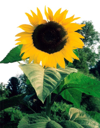

In [ ]:
image = Image.open(dest)
image.to_thumb(128, 128)

### Get all of the images

In [ ]:
data_path = "data"
if not os.path.exists(data_path):
  os.mkdir(data_path)

for Wildflower in Wildflower_species:

  dest = f"{data_path}/{Wildflower}"
  if not os.path.exists(dest):
    os.mkdir(dest)

  try:
    Wildflower_image_urls = search_images_ddg(Wildflower)
    download_images(dest, urls = Wildflower_image_urls)

  except:
    continue

In [ ]:
image_counts = get_image_files(data_path)
image_counts

(#4743) [Path('data/Sunflower/ae85dbcb-f0e4-4f79-8c3c-56729c32f665.jpg'),Path('data/Sunflower/e60a689a-609d-49c9-8e25-e72480b3b4e8.jpg'),Path('data/Sunflower/f6adf044-a189-4e08-9bed-09b9edfd1b20.jpg'),Path('data/Sunflower/57a387ff-a090-41a2-930f-0d06b098868f.jpg'),Path('data/Sunflower/3ce46a27-eb4d-499d-8b5a-51260eb3f29d.jpg'),Path('data/Sunflower/5e8aa0dd-c9bb-4383-9ae0-4b976507bd9f.jpg'),Path('data/Sunflower/3dc7f6ba-201f-45b6-b65e-6e061fa85c34.jpg'),Path('data/Sunflower/ab884a77-e65f-4246-8ceb-0225b98b3f1c.jpg'),Path('data/Sunflower/ba621064-ac35-4d94-bfb4-a50d857a7458.jpg'),Path('data/Sunflower/c3a95dc6-60f5-428c-b45a-51226521d946.jpg')...]

In [ ]:
failed = verify_images(image_counts)
failed

(#223) [Path('data/Sunflower/ba621064-ac35-4d94-bfb4-a50d857a7458.jpg'),Path('data/Sunflower/de00e8c6-ade2-4d49-bf06-6a3f85985f37.jpg'),Path('data/Sunflower/49362af3-f02e-4308-b031-2034fdbb9e92.jpg'),Path('data/Sunflower/4f10a448-2c16-423d-9856-62a99020ea86.jpg'),Path('data/Sunflower/e6e6709e-c621-4c5b-a0fc-98617d5f95fe.jpg'),Path('data/Sunflower/ab5b2f18-45f8-4c0c-ac70-df13be466e6f.jpg'),Path('data/Sunflower/f1c6f840-3d0f-4e03-8d72-5be50b6254dd.jpg'),Path('data/Sunflower/90ac4cdf-2aed-4f57-a516-5f1c88534496.jpg'),Path('data/Sunflower/77dfd463-1274-4c3d-a10f-af5f9b9de34f.jpg'),Path('data/Sunflower/91d031c1-c8ef-4329-824e-ad017bb8ef43.jpg')...]

In [ ]:
failed.map(Path.unlink)

(#223) [None,None,None,None,None,None,None,None,None,None...]

## From Data to Data Loaders

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,                        # get_image_files returns a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # getting 90-10 train-validation split
    get_y=parent_label,                               # taking the folder name as labels
    item_tfms=Resize(128))                            # resizing to get the image of same shape

In [ ]:
dls = dblock.dataloaders(data_path,bs=bs)             # setting up batch size for efficient GPU use

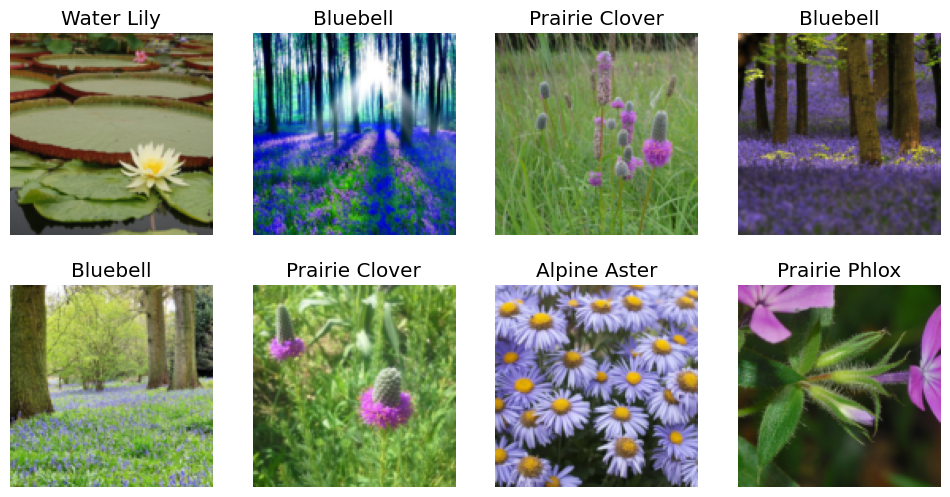

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

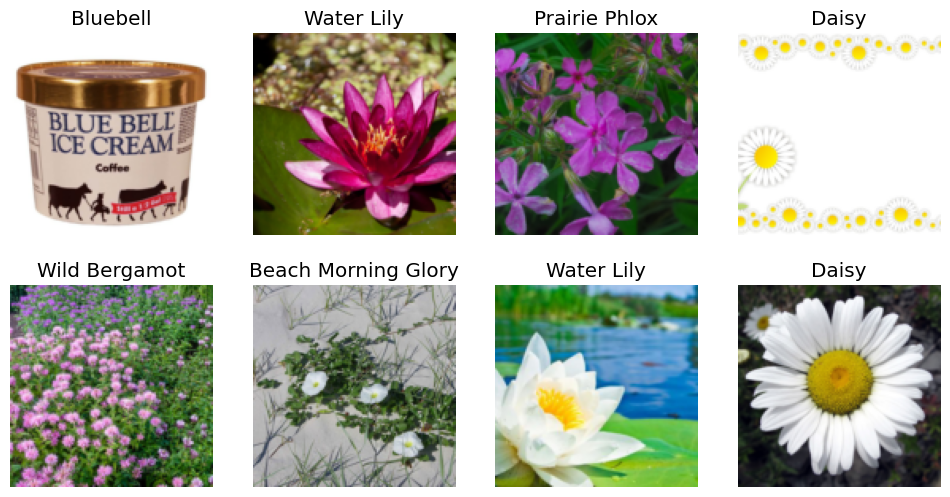

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

## Data Augmentation

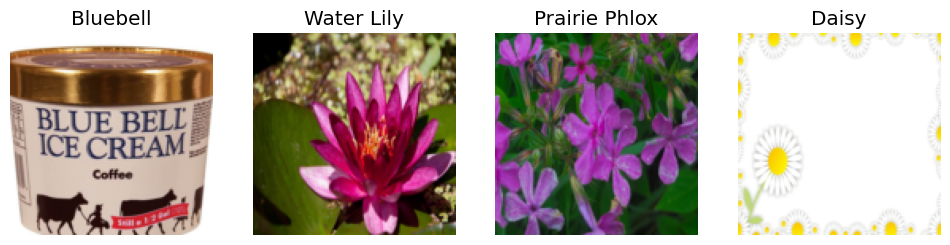

In [ ]:
dblock = dblock.new(item_tfms=RandomResizedCrop(128, min_scale=0.3)) # Randomly cropping, cutting, resizing, coloring parts of image into (128 x 128) size
dls = dblock.dataloaders(data_path)
dls.valid.show_batch(max_n=4, nrows=1)

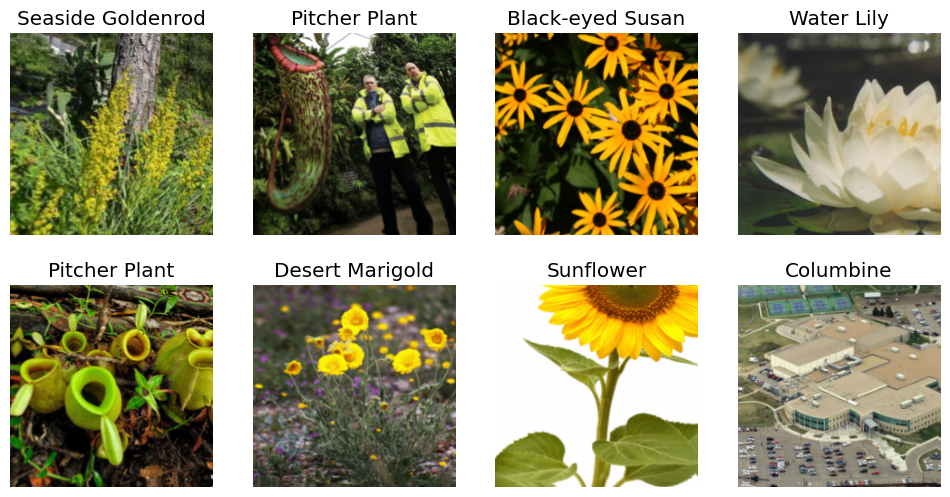

In [ ]:
# RandomResizedCrop crops images randomly and create copies so that we don't miss out anything
# aug_transforms is used for image data augmentation
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(data_path)
dls.train.show_batch(max_n=8, nrows=2)

In [ ]:
torch.save(dls, "Wildflower_dataloader_v0.pkl")